# Explore the composition of Illumina RNA seq data sets in the Sequence Read Archive

In [ ]:
setwd("..")

In [4]:
library(dplyr)
library(janitor)
library(purrr)
library(readr)
library(ggplot2)
library(tidyr)

## Download and read metadata files

In [6]:
destfile <- "inputs/gtdb/bac120_metadata_r202.tar.gz"
url <- "https://data.ace.uq.edu.au/public/gtdb/data/releases/release202/202.0/bac120_metadata_r202.tar.gz"
if (!file.exists(destfile)) {
  download.file(url, destfile, method="auto") 
}
outfile <- "inputs/gtdb/bac120_metadata_r202.tsv"
if (!file.exists(outfile)){
  untar(destfile, exdir = "inputs/gtdb")
}

destfile <- "inputs/gtdb/ar122_metadata_r202.tar.gz"
url <- "https://data.ace.uq.edu.au/public/gtdb/data/releases/release202/202.0/ar122_metadata_r202.tar.gz"
if (!file.exists(destfile)) {
  download.file(url, destfile, method="auto") 
}
outfile <- "inputs/gtdb/ar122_metadata_r202.tsv"
if (!file.exists(outfile)){
  untar(destfile, exdir = "inputs/gtdb")
}

In [8]:
gtdb_metadata <- read_tsv("inputs/gtdb/bac120_metadata_r202.tsv", show_col_types = FALSE) %>%
  separate(gtdb_taxonomy, into = c("domain", "phylum", "class", "order", "family", "genus", "species"), 
           sep = ";") %>%
  mutate(accession = gsub("GB_", "", accession)) %>%
  mutate(accession = gsub("RS_", "", accession))

gtdb_metadata <- read_tsv("inputs/gtdb/ar122_metadata_r202.tsv", show_col_types = FALSE) %>%
  separate(gtdb_taxonomy, into = c("domain", "phylum", "class", "order", "family", "genus", "species"), 
           sep = ";") %>%
  mutate(accession = gsub("GB_", "", accession)) %>%
  mutate(accession = gsub("RS_", "", accession)) %>%
  bind_rows(gtdb_metadata)

Warning message:
“One or more parsing issues, see `problems()` for details”


In [9]:
# try and fine a way to programatically generate this file;
# should be able to do it with https://www.bioconductor.org/packages/release/bioc/html/SRAdb.html,
# but requires 35gb sqlite file, so wait to integrate until hpc access.
# in the mean time, this files was generated on 01/14/2022 at https://www.ncbi.nlm.nih.gov/sra/
# using search criteria 
# ("Bacteria"[Organism] OR "Archaea"[Organism]) AND ("biomol rna"[Properties] AND "platform illumina"[Properties] AND "filetype fastq"[Properties]) 
# Then, from send to button in upper right corner, file, summary format
sra <- read_csv("inputs/20220114_sra_results.csv", show_col_types = FALSE) %>%
  janitor::clean_names() %>%
  filter(library_source == "TRANSCRIPTOMIC") %>%
  filter(library_strategy %in% c("RNA-Seq", "OTHER")) %>%
  filter(library_selection %in% c("cDNA", "other", "RANDOM", "unspecified", "RT-PCR", "RANDOM PCR", "PCR"))

Warning message:
“One or more parsing issues, see `problems()` for details”


## Descriptive stats & numbers for SRA

In [10]:
# how many total RNA seq experiments are there?
nrow(sra)

[1] 54445

In [11]:
# how many distinct species are there (using NCBI taxonomy)?
length(unique(sra$organism_name)) 

[1] 1722

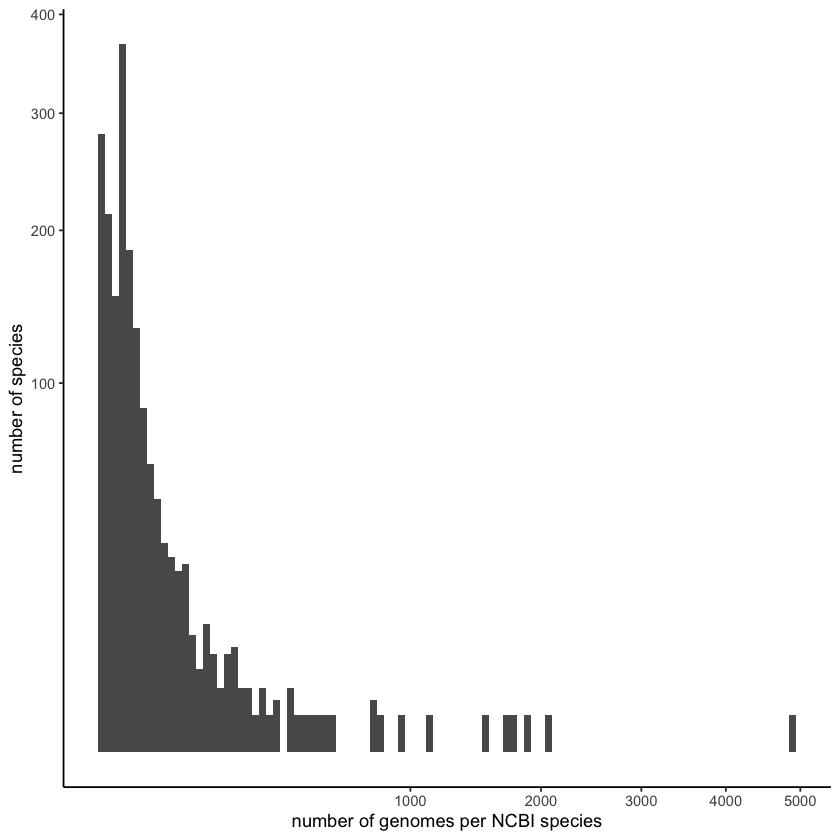

In [12]:
# what is the distribution of the number of data sets per species?
sra_org_tally <- sra %>% group_by(organism_name) %>% tally()
ggplot(sra_org_tally, aes(x = n)) +
  geom_histogram(bins = 100) +
  theme_classic() +
  scale_y_sqrt() +
  scale_x_sqrt() +
  labs(x = "number of genomes per NCBI species", y = "number of species")

In [13]:
# what is the average read length
mean(sra$total_bases/sra$total_spots, na.rm = T)
sra <- sra %>%
  mutate(mean_read_length = total_bases/total_spots)

[1] 154.8695

Warning message:
“Removed 961 rows containing non-finite values (stat_bin).”


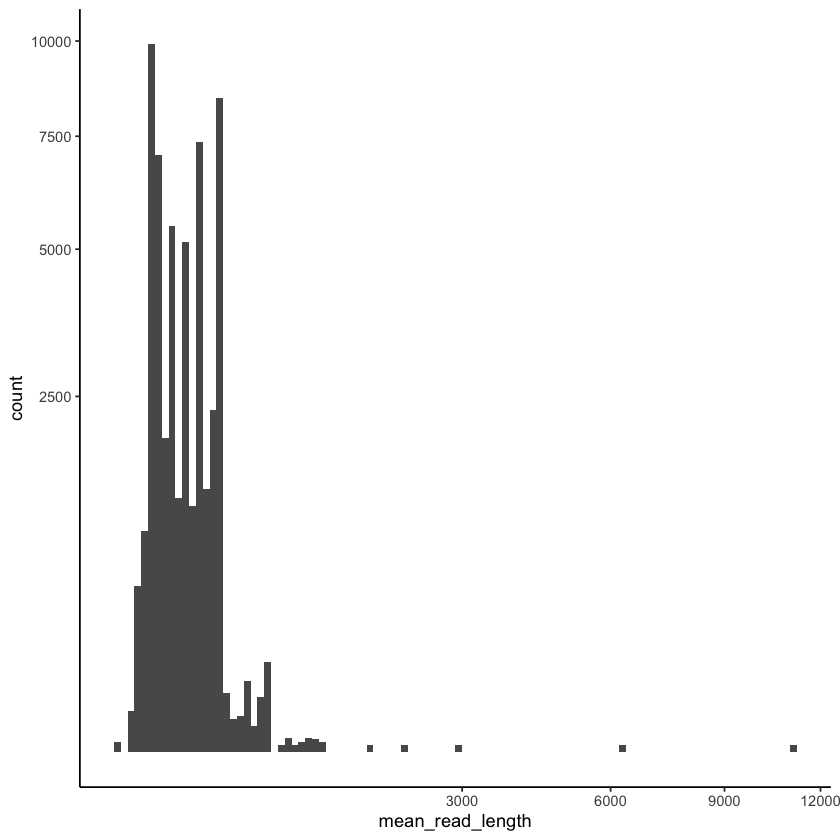

In [14]:
ggplot(sra, aes(x = mean_read_length))  +
  geom_histogram(bins = 100) +
  theme_classic() +
  scale_y_sqrt() +
  scale_x_sqrt()

In [15]:
table(sra$mean_read_length < 31)


FALSE  TRUE 
53168   316 

## Descriptive stats & numbers for GTDB

In [17]:
# make gtdb to ncbi map
gtdb_to_ncbi_map <- gtdb_metadata %>%
  select(ncbi_organism_name, domain, phylum, class, order, family, genus, species) %>%
  distinct()
  
# create map of GTDB to NCBI 
sra_to_gtdb_map <- sra %>%
  select(organism_name) %>%
  distinct() %>%
  left_join(gtdb_to_ncbi_map, by = c("organism_name" = "ncbi_organism_name"))

In [18]:
# how many data sets don't have a representative genome within the GTDB taxonomy,
# using only GTDB <-> SRA taxonomy map (as opposed to using sourmash gather to
# infer the species). Note species map fails when species is labelled wrong, which
# happens at least sometimes (determined by eye).

sra_with_gtdb <- sra %>%
  left_join(sra_to_gtdb_map)

sra_no_gtdb_species <- sra_with_gtdb[is.na(sra_with_gtdb$species), ]
nrow(sra_no_gtdb_species) # 3,274 samples don't have a species by text-based analysis

Joining, by = "organism_name"



[1] 3274

In [19]:
length(unique(sra_no_gtdb_species$organism_name)) # 344 species don't have species-level ref genomes in GTDB by text-based analysis

[1] 344

In [20]:
## how many distinct species are there (using GTDB taxonomy)?
sra_with_gtdb_has_species <- sra_with_gtdb[!is.na(sra_with_gtdb$species), ]
length(unique(sra_with_gtdb_has_species$organism_name)) # 1,378 in NCBI taxonomy
length(unique(sra_with_gtdb_has_species$species)) # 2,524 in GTDB taxonomy with text-based analysis

[1] 1378

[1] 2524

In [21]:
sra_with_gtdb_has_species_tally <- sra_with_gtdb_has_species %>%
  group_by(species) %>%
  tally()
mean(sra_with_gtdb_has_species_tally$n)

[1] 114.0955

In [22]:
# how many species are bacteria? archaea?
 
sra_with_gtdb_has_species_slice <- sra_with_gtdb_has_species %>%
  group_by(experiment_accession) %>%
  slice(1) # only count each experiment onces
table(sra_with_gtdb_has_species_slice$domain) # d__Archaea: 989 d__Bacteria: 50,18


 d__Archaea d__Bacteria 
        989       50182 

## Selecting suitable test species

In [23]:
# pick a second organism to work with whose pangenome isn't quite as large as Pseudomonas a.

gtdb_num_species <- gtdb_metadata %>%
  select(species) %>%
  group_by(species) %>%
  tally() %>%
  select(species, num_genomes_in_gtdb = n)

tmp <- sra_with_gtdb_has_species_tally %>%
  left_join(gtdb_num_species, by = "species")

tmp %>%
       filter(n > 20, num_genomes_in_gtdb > 20) %>%
       filter(n < 80, num_genomes_in_gtdb < 100)

species,n,num_genomes_in_gtdb
<chr>,<int>,<int>
s__Achromobacter xylosoxidans,52,63
s__Aeromonas dhakensis,28,34
s__Aeromonas hydrophila,34,92
s__Agrobacterium deltaense,78,26
s__Agrobacterium pusense,78,76
s__Alistipes onderdonkii,37,21
s__Bacillus altitudinis,36,94
s__Bacillus safensis,31,71
s__Bacteroides ovatus,33,73
